# Algoritmo Genético para Selección de Características

Este notebook implementa un **algoritmo genético** para realizar **selección de características** en el conjunto de datos de **cáncer de mama** de `sklearn`. Utilizamos un **árbol de decisión** como clasificador y validación cruzada para evaluar la aptitud de las soluciones.

Vamos a dividir el código en secciones con explicaciones detalladas para que puedas entender cada parte del proceso.

---

## 1. Importación de Librerías
Primero, necesitamos importar las librerías necesarias para nuestro algoritmo genético y el manejo de los datos.


In [1]:
# Importar las librerías necesarias
import random
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


En esta celda, estamos importando:

- **`random`**: Para manejar las aleatoriedades en el algoritmo genético (como la selección por torneo, el cruce y la mutación).
- **`numpy`**: Para manejar arrays y matrices de manera eficiente, que es especialmente útil para trabajar con las poblaciones de los individuos.
- **`sklearn.datasets`**: Para cargar el dataset de cáncer de mama.
- **`sklearn.model_selection`**: Para hacer validación cruzada con el modelo de clasificación.
- **`sklearn.tree`**: Para usar un clasificador de árbol de decisión en la evaluación de la aptitud.
- **`matplotlib.pyplot`**: Para graficar el progreso del algoritmo genético a través de las generaciones.


### Dataset: Cáncer de Mama

El conjunto de datos **cáncer de mama** contiene 30 características que describen varias medidas de las células tumorales. El objetivo es predecir si el tumor es maligno o benigno, basado en estas características. Las características incluyen el radio, la textura, el perímetro, el área, la suavidad, etc.

Vamos a cargar el dataset y ver cómo se organiza.


In [2]:
# Cargar el dataset de cáncer de mama
data = load_breast_cancer()
X = data.data
y = data.target

# Mostrar algunas características del dataset para entenderlo mejor
print("Características del dataset:")
print(data.feature_names)
print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Características del dataset:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Forma de X: (569, 30)
Forma de y: (569,)


**Explicación**:

- **`X`** contiene las características del dataset (30 columnas).
- **`y`** contiene las etiquetas de clase (0 = benigno, 1 = maligno).

Aquí imprimimos el nombre de las características y las dimensiones de los datos para obtener una idea general del conjunto de datos.


### Parámetros del Algoritmo Genético

El algoritmo genético requiere varios parámetros que controlan el proceso de evolución. Aquí definimos algunos de los más importantes:

- **Tamaño de la población (`POPULATION_SIZE`)**: Cuántos individuos habrá en cada generación.
- **Número de generaciones (`GENERATIONS`)**: Cuántas iteraciones del algoritmo vamos a realizar.
- **Tamaño del torneo (`TOURNAMENT_SIZE`)**: Número de individuos seleccionados en cada torneo.
- **Probabilidad de cruce (`CROSSOVER_PROBABILITY`)**: La probabilidad de que ocurra un cruce entre dos padres para generar hijos.
- **Probabilidad de mutación (`MUTATION_PROBABILITY`)**: La probabilidad de que un individuo sufra una mutación en algún gen.

Veamos cómo los definimos en el código.


In [3]:
# Parámetros del algoritmo genético
POPULATION_SIZE = 20  # Tamaño de la población
GENERATIONS = 50  # Número de generaciones
TOURNAMENT_SIZE = 5  # Número de individuos en el torneo de selección
CROSSOVER_PROBABILITY = 0.8  # Probabilidad de cruce
MUTATION_PROBABILITY = 0.2  # Probabilidad de mutación


**Explicación**:

- **Población de tamaño 20**: Usamos una población moderada de 20 individuos para balancear la diversidad y el tiempo de ejecución.
- **Generaciones de 50**: El número de generaciones se elige para asegurarse de que el algoritmo tenga tiempo suficiente para evolucionar y converger hacia una solución óptima.
- **Probabilidades de cruce y mutación**: Elegimos probabilidades de cruce del 80% y mutación del 20%, lo que es bastante común en los algoritmos genéticos. Esto significa que, en cada iteración, el 80% de los pares de padres sufrirán cruce, mientras que el 20% tendrán mutaciones.


### Inicialización de la Población

Cada individuo es un vector binario, donde cada bit representa si una característica es seleccionada (1) o no (0). El número total de características es 30, por lo que cada individuo tiene 30 bits. Inicializamos la población de forma aleatoria.


In [4]:
# Inicialización de la población
initialPopulation = np.random.randint(2, size=(POPULATION_SIZE, X.shape[1]))  # Población aleatoria de 0s y 1s

# Ver los primeros individuos de la población
print("Población inicial (algunos individuos):")
print(initialPopulation[:5])  # Mostrar los primeros 5 individuos


Población inicial (algunos individuos):
[[1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1]
 [0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1]
 [1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0]
 [0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1]]


**Explicación**:

- **Población**: Es un arreglo de tamaño `(POPULATION_SIZE, 30)` (20 individuos, 30 características). Cada elemento del arreglo es un valor binario (0 o 1) que indica si esa característica está seleccionada o no.
- Aquí mostramos los primeros 5 individuos para tener una idea de cómo es la población inicial.


### Algoritmo Genético

El algoritmo genético simula el proceso de evolución de las especies para encontrar la mejor combinación de características. Esto se hace mediante la selección, el cruce y la mutación de los individuos en cada generación.

**Métodos del algoritmo**:

1. **`fitnessFunction`**: Evalúa qué tan bueno es un individuo según su capacidad para clasificar correctamente los datos usando el árbol de decisión.
2. **`tournamentSelection`**: Selecciona dos padres por torneo.
3. **`crossover`**: Realiza el cruce de dos individuos para generar dos hijos.
4. **`mutate`**: Realiza una mutación aleatoria en el individuo.
5. **`run`**: Ejecuta el algoritmo durante varias generaciones.


In [ ]:
class GeneticAlgorithm:
    def __init__(self, population):
        self.population = population
        # Inicializamos los mejores valores con el primer individuo de la población
        self.bestIndividual = self.population[0].copy()
        self.bestFitness = self.fitnessFunction(self.bestIndividual)  # Calcular la aptitud del primer individuo

    def fitnessFunction(self, individual):
        """
        Función de aptitud que calcula el rendimiento del clasificador (en este caso, un árbol de decisión) 
        usando las características seleccionadas por el individuo.
        """
        # Filtrar las características seleccionadas
        selectedFeatures = [index for index in range(len(individual)) if individual[index] == 1]
        
        # Si no hay características seleccionadas, la aptitud es 0 (el modelo no puede entrenarse sin características)
        if len(selectedFeatures) == 0:
            return 0.0
        
        X_selected = X[:, selectedFeatures]  # Subconjunto de características seleccionadas
        classifier = DecisionTreeClassifier()  # Modelo de clasificador
        scores = cross_val_score(classifier, X_selected, y, cv=5)  # Validación cruzada con 5 divisiones
        return scores.mean()  # La aptitud es la media de las puntuaciones obtenidas

    def tournamentSelection(self):
        """
        Selección por torneo: elegimos aleatoriamente un grupo de individuos y seleccionamos el mejor.
        """
        tournament = random.sample(list(self.population), TOURNAMENT_SIZE)  # Elegir aleatoriamente a los competidores
        tournamentFitness = [self.fitnessFunction(ind) for ind in tournament]  # Calcular la aptitud de cada uno
        winnerIndex = np.argmax(tournamentFitness)  # Encontrar el índice del individuo con mejor aptitud
        return tournament[winnerIndex]  # Devolver el individuo ganador

    def crossover(self, parent1, parent2):
        """
        Cruce de dos individuos para generar dos hijos.
        Realizamos un cruce de tipo "un punto", donde se selecciona un punto aleatorio en el cromosoma y se intercambia.
        """
        if random.random() < CROSSOVER_PROBABILITY:  # Si se cumple la probabilidad de cruce
            point = random.randint(1, len(parent1) - 1)  # Elegir el punto de cruce aleatorio
            # Generar los hijos intercambiando las partes de los padres
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()  # Sin cruce, los hijos son copias de los padres

    def mutate(self, individual):
        """
        Mutación de un individuo: cambiamos aleatoriamente un gen del cromosoma (de 0 a 1 o de 1 a 0).
        """
        for index in range(len(individual)):
            if random.random() < MUTATION_PROBABILITY:  # Si se cumple la probabilidad de mutación
                individual[index] = 1 - individual[index]  # Cambiar el valor de 0 a 1 o de 1 a 0
        return individual

    def run(self):
        """
        Ejecutamos el algoritmo genético durante un número fijo de generaciones.
        """
        best_fitnesses = []  # Lista para almacenar las mejores aptitudes por generación
        for generation in range(GENERATIONS):
            newPopulation = []  # Nueva población

            # Agregar elitismo: conservar el mejor individuo
            best_individual = self.bestIndividual.copy()
            best_fitness = self.bestFitness
            newPopulation.append(best_individual)

            while len(newPopulation) < POPULATION_SIZE:  # Hasta completar el tamaño de la población
                parent1 = self.tournamentSelection()  # Seleccionar al primer padre
                parent2 = self.tournamentSelection()  # Seleccionar al segundo padre
                child1, child2 = self.crossover(parent1, parent2)  # Realizar el cruce
                child1 = self.mutate(child1)  # Mutar al primer hijo
                child2 = self.mutate(child2)  # Mutar al segundo hijo
                newPopulation.append(child1)  # Añadir el primer hijo
                newPopulation.append(child2)  # Añadir el segundo hijo

            # Reducir tamaño de población en caso de exceder el número deseado
            self.population = np.array(newPopulation[:POPULATION_SIZE])

            # Evaluar la mejor aptitud en esta generación
            generationBestFitness = 0.0
            generationBestIndividual = None
            for individual in self.population:
                fitness = self.fitnessFunction(individual)
                if fitness > generationBestFitness:
                    generationBestFitness = fitness
                    generationBestIndividual = individual

            # Actualizar el mejor individuo global si es necesario
            if generationBestFitness > self.bestFitness:
                self.bestFitness = generationBestFitness
                self.bestIndividual = generationBestIndividual

            best_fitnesses.append(generationBestFitness)  # Guardar la mejor aptitud de esta generación
            print(f"Generación {generation + 1}: Mejor Aptitud = {generationBestFitness:.4f}")

        # Mostrar el resultado final
        print(f"Aptitud Global Mejor: {self.bestFitness:.4f}")
        print(f"Mejor Individuo Global: {self.bestIndividual}")

        # Graficar el progreso de la aptitud
        plt.plot(best_fitnesses)
        plt.xlabel('Generaciones')
        plt.ylabel('Mejor Aptitud')
        plt.title('Progreso del Algoritmo Genético')
        plt.show()


### Ejecutando el Algoritmo Genético

Ahora que hemos definido la clase `GeneticAlgorithm`, creamos una instancia de ella con la población inicial y ejecutamos el algoritmo. Al final, se mostrará el gráfico con la evolución de la aptitud a través de las generaciones.


Generación 1: Mejor Aptitud = 0.9437
Generación 2: Mejor Aptitud = 0.9490
Generación 3: Mejor Aptitud = 0.9508
Generación 4: Mejor Aptitud = 0.9526
Generación 5: Mejor Aptitud = 0.9543
Generación 6: Mejor Aptitud = 0.9596
Generación 7: Mejor Aptitud = 0.9508
Generación 8: Mejor Aptitud = 0.9526
Generación 9: Mejor Aptitud = 0.9561
Generación 10: Mejor Aptitud = 0.9490
Generación 11: Mejor Aptitud = 0.9491
Generación 12: Mejor Aptitud = 0.9473
Generación 13: Mejor Aptitud = 0.9578
Generación 14: Mejor Aptitud = 0.9508
Generación 15: Mejor Aptitud = 0.9526
Generación 16: Mejor Aptitud = 0.9543
Generación 17: Mejor Aptitud = 0.9578
Generación 18: Mejor Aptitud = 0.9543
Generación 19: Mejor Aptitud = 0.9508
Generación 20: Mejor Aptitud = 0.9543
Generación 21: Mejor Aptitud = 0.9525
Generación 22: Mejor Aptitud = 0.9543
Generación 23: Mejor Aptitud = 0.9508
Generación 24: Mejor Aptitud = 0.9473
Generación 25: Mejor Aptitud = 0.9508
Generación 26: Mejor Aptitud = 0.9473
Generación 27: Mejor 

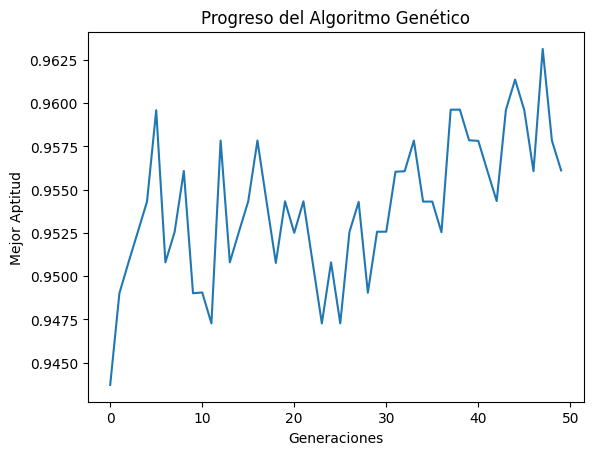

In [6]:
# Crear una instancia del algoritmo genético y ejecutarlo
ga = GeneticAlgorithm(initialPopulation)
ga.run()
